# CNN pruning and quantization




Quantization allows for decreasing data memory size necessary to store them.

Also allows for faster computation with dedicated devices like embedded GPU and FPGA.

Applying quantization on continues data creates regions of attraction.

Values from some range are assigned to proper value that represents that range.

That also increase the level of correlation between quantized filters, 

so allows for more effective pruning.

That results with much more smaller network than at the beginning.  

In [4]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [5]:
import torch
from torchvision import datasets
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt
import random
from typing import List, Tuple, Dict
from copy import deepcopy

# local_utils file contains util functions for training or display
# CHECK IT
import local_utils as lu

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

def set_random_seed(seed:int = 0):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    

cuda


Datasets

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

len(train_loader) = 938
len(test_loader) = 157
torch.Size([64, 1, 28, 28])
torch.Size([64])


<Figure size 432x288 with 0 Axes>

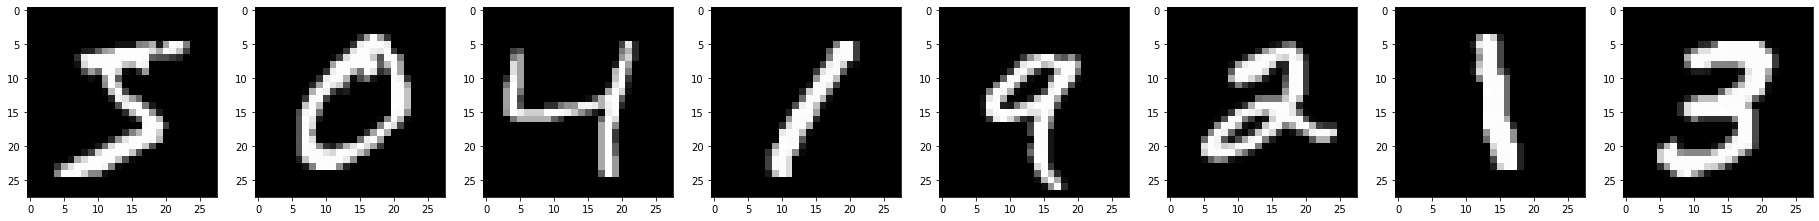

In [6]:
from torchvision.transforms import ToTensor

BATCH_SIZE = 64
set_random_seed(0)

train_dataset = datasets.MNIST('data', 
                              train=True,
                              download=True,
                              transform=ToTensor())
test_dataset = datasets.MNIST('data', 
                              train=False,
                              download=True,
                              transform=ToTensor())

train_loader = DataLoader(train_dataset, 
                          batch_size=BATCH_SIZE,
                          shuffle=False)
test_loader = DataLoader(test_dataset, 
                          batch_size=BATCH_SIZE,
                          shuffle=False)

print("len(train_loader) =", len(train_loader))
print("len(test_loader) =", len(test_loader))

plt.gray()
loader = train_loader
for X, y in loader:
    print(X.shape)
    print(y.shape)
    
    ROWS, COLS = 1, 8
    fig, axs = plt.subplots(ROWS, COLS)
    fig.set_size_inches(COLS*4,ROWS*4)
    axs = np.array(axs).flatten().tolist()
    
    for i, ax in enumerate(axs):
        img = X[i,...]
        class_label = loader.dataset.classes[y[i]]
        ax.imshow(img.squeeze())
    plt.show()
    break

Network definition and training

Run network training - it spends very long time, so for only your code check you can run only one epoch.

When you check your code back to 30 epochs :) .

In [7]:
!pip install brevitas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.3/357.3 KB 17.6 MB/s eta 0:00:00


In [8]:
from brevitas.nn import QuantConv2d, QuantIdentity
from brevitas.quant.scaled_int import Int8WeightPerTensorFloat, \
    Int8BiasPerTensorFloatInternalScaling, Int8ActPerTensorFloat


class NeuralNetwork(nn.Module):
    def __init__(self, 
                 input_shape=(1,28,28), 
                 num_of_classes=10,
                 channels = [16,32,64,128], # number of conv filters 
                 ksize   =  [3, 3, 3, 3], # kernels sizes
                 padding =  [1, 1, 0, 0], # padding sizes
                 max_pool = [1, 1, 0, 0], # use maxpool after conv or not
                 quantize=True,
                 bit_width=4
                 ) -> None:
        super().__init__()
        channels = [input_shape[0]]+channels
        padding = [1,1,0,0]
        max_pool = [1,1,0,0]
        
        if quantize:
            input_quant = QuantIdentity(Int8ActPerTensorFloat, min_val=-1.0, max_val=1.0, bit_width=bit_width)
        else:
            input_quant = QuantIdentity(None)
        
        layers = []
        self.conv_layers = []
        map_shape = [input_shape[0],input_shape[1],input_shape[2]]
        for i, (ch_in, ch_out, ks, p, mp) in enumerate(zip(channels[:-1],
                                                       channels[1:],
                                                       ksize,
                                                       padding,
                                                       max_pool)):
            conv = QuantConv2d(ch_in, ch_out, ks, padding=p, bias=True, 
                               weight_quant=Int8WeightPerTensorFloat if quantize else None,
                               bias_quant=Int8BiasPerTensorFloatInternalScaling if quantize else None,
                               weight_bit_width=bit_width,
                               bias_bit_width=bit_width,
                               return_quant_tensor=False
                               )
            # shape modification
            map_shape[0] = ch_out
            map_shape[1] = map_shape[1] - 2*(ks//2 - p)
            map_shape[2] = map_shape[2] - 2*(ks//2 - p)
            
            # store conv layers for further analysis and prunning
            self.conv_layers.append(conv)
            # add to all layers
            layers.append(conv)
            
            if quantize:
                out_quant = QuantIdentity(Int8ActPerTensorFloat, min_val=-1.0, max_val=1.0, bit_width=bit_width)
            else:
                out_quant = QuantIdentity(None)
            
            layers.append(out_quant)
            relu = nn.ReLU()
            layers.append(relu)
            
            if mp:
                maxpool = nn.MaxPool2d(2,2)
                # shape modification
                map_shape[1] = map_shape[1] // 2
                map_shape[2] = map_shape[2] // 2
                layers.append(maxpool)
        
        self.CNN = nn.Sequential(input_quant, *tuple(layers))
        
        CNN_flatten_len = torch.prod(torch.tensor(map_shape))
        print(f"CNN out map shape = {map_shape}")
        print(f"CNN out map numel = {CNN_flatten_len}")
        self.flatten = nn.Flatten()
        self.FC = nn.Linear(CNN_flatten_len, num_of_classes)
        self.sm = nn.Softmax(1)
    
    def forward(self, x: torch.Tensor):
        x = self.CNN(x)
        x = self.flatten(x)
        x = self.FC(x)
        x = self.sm(x)
        return x

set_random_seed(0)
net = NeuralNetwork(input_shape=(1,28,28), 
                    num_of_classes=10,
                    channels = [32,32,32,32], # number of conv filters 
                    ksize   =  [3, 3, 3, 3], # kernels sizes
                    padding =  [1, 1, 0, 0], # padding sizes
                    max_pool = [1, 1, 0, 0], # use maxpool after conv or not
                    quantize=True
                    ).to(device)
net_param_number = lu.count_params(net)
print(f"Network paramerters number: {net_param_number}")

set_random_seed(0)
metric = lu.AccuracyMetic()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.1, momentum=0.8, weight_decay=0.0001)

set_random_seed(0)
net, history = lu.training(net, train_loader, test_loader, criterion, metric, optimizer, 5, 30, device=device)

CNN out map shape = [32, 3, 3]
CNN out map numel = 288
Network paramerters number: 30959
Epoch 1 / 30: STARTED
TRAINING
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


938it [00:34, 27.55it/s]


VALIDATION
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


157it [00:02, 64.49it/s]


After epoch 1: loss=1.9282 acc=0.5357 val_loss=1.6971 val_acc=0.7625
Epoch 1 / 30: FINISHED

Epoch 2 / 30: STARTED
TRAINING
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


938it [00:21, 44.58it/s]


VALIDATION
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


157it [00:02, 63.90it/s]


After epoch 2: loss=1.6919 acc=0.7682 val_loss=1.6764 val_acc=0.7839
Epoch 2 / 30: FINISHED

Epoch 3 / 30: STARTED
TRAINING
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


938it [00:20, 45.36it/s]


VALIDATION
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


157it [00:02, 63.86it/s]


After epoch 3: loss=1.6205 acc=0.8400 val_loss=1.5915 val_acc=0.8686
Epoch 3 / 30: FINISHED

Epoch 4 / 30: STARTED
TRAINING
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


938it [00:20, 45.96it/s]


VALIDATION
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


157it [00:02, 61.87it/s]


After epoch 4: loss=1.5844 acc=0.8765 val_loss=1.5799 val_acc=0.8802
Epoch 4 / 30: FINISHED

Epoch 5 / 30: STARTED
TRAINING
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


938it [00:20, 45.81it/s]


VALIDATION
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


157it [00:02, 63.25it/s]


After epoch 5: loss=1.5801 acc=0.8805 val_loss=1.5789 val_acc=0.8805
Epoch 5 / 30: FINISHED

Epoch 6 / 30: STARTED
TRAINING
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


938it [00:20, 45.10it/s]


VALIDATION
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


157it [00:02, 63.28it/s]


After epoch 6: loss=1.5759 acc=0.8848 val_loss=1.5766 val_acc=0.8836
Epoch 6 / 30: FINISHED

Epoch 7 / 30: STARTED
TRAINING
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


938it [00:20, 45.42it/s]


VALIDATION
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


157it [00:02, 63.50it/s]


After epoch 7: loss=1.5743 acc=0.8863 val_loss=1.5748 val_acc=0.8854
Epoch 7 / 30: FINISHED

Epoch 8 / 30: STARTED
TRAINING
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


938it [00:21, 44.29it/s]


VALIDATION
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


157it [00:02, 61.48it/s]


After epoch 8: loss=1.5720 acc=0.8883 val_loss=1.5741 val_acc=0.8862
Epoch 8 / 30: FINISHED

Epoch 9 / 30: STARTED
TRAINING
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


938it [00:21, 44.51it/s]


VALIDATION
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


157it [00:02, 63.72it/s]


After epoch 9: loss=1.5708 acc=0.8893 val_loss=1.5720 val_acc=0.8882
Epoch 9 / 30: FINISHED

Epoch 10 / 30: STARTED
TRAINING
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


938it [00:20, 45.25it/s]


VALIDATION
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


157it [00:02, 60.42it/s]


After epoch 10: loss=1.5695 acc=0.8907 val_loss=1.5725 val_acc=0.8871
Epoch 10 / 30: FINISHED

Epoch 11 / 30: STARTED
TRAINING
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


938it [00:20, 45.50it/s]


VALIDATION
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


157it [00:02, 60.12it/s]


After epoch 11: loss=1.5692 acc=0.8909 val_loss=1.5709 val_acc=0.8886
Epoch 11 / 30: FINISHED

Epoch 12 / 30: STARTED
TRAINING
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


938it [00:21, 44.58it/s]


VALIDATION
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


157it [00:02, 62.76it/s]


After epoch 12: loss=1.5680 acc=0.8918 val_loss=1.5719 val_acc=0.8878
Epoch 12 / 30: FINISHED

Epoch 13 / 30: STARTED
TRAINING
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


938it [00:20, 45.54it/s]


VALIDATION
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


157it [00:02, 63.68it/s]


After epoch 13: loss=1.5667 acc=0.8929 val_loss=1.5690 val_acc=0.8901
Epoch 13 / 30: FINISHED

Epoch 14 / 30: STARTED
TRAINING
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


938it [00:20, 45.16it/s]


VALIDATION
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


157it [00:02, 62.46it/s]


After epoch 14: loss=1.5661 acc=0.8936 val_loss=1.5709 val_acc=0.8890
Epoch 14 / 30: FINISHED

Epoch 15 / 30: STARTED
TRAINING
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


938it [00:21, 44.56it/s]


VALIDATION
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


157it [00:02, 63.53it/s]


After epoch 15: loss=1.5656 acc=0.8937 val_loss=1.5687 val_acc=0.8905
Epoch 15 / 30: FINISHED

Epoch 16 / 30: STARTED
TRAINING
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


938it [00:20, 45.35it/s]


VALIDATION
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


157it [00:02, 62.98it/s]


After epoch 16: loss=1.5651 acc=0.8944 val_loss=1.5700 val_acc=0.8888
Epoch 16 / 30: FINISHED

Epoch 17 / 30: STARTED
TRAINING
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


938it [00:20, 44.95it/s]


VALIDATION
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


157it [00:02, 61.95it/s]


After epoch 17: loss=1.5648 acc=0.8943 val_loss=1.5690 val_acc=0.8894
Epoch 17 / 30: FINISHED

Epoch 18 / 30: STARTED
TRAINING
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


938it [00:20, 44.95it/s]


VALIDATION
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


157it [00:02, 62.66it/s]


After epoch 18: loss=1.5639 acc=0.8952 val_loss=1.5682 val_acc=0.8902
Epoch 18 / 30: FINISHED

Epoch 19 / 30: STARTED
TRAINING
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


938it [00:20, 44.89it/s]


VALIDATION
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


157it [00:02, 63.57it/s]


After epoch 19: loss=1.5634 acc=0.8956 val_loss=1.5674 val_acc=0.8909
Epoch 19 / 30: FINISHED

Epoch 20 / 30: STARTED
TRAINING
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


938it [00:21, 44.56it/s]


VALIDATION
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


157it [00:02, 62.93it/s]


After epoch 20: loss=1.5631 acc=0.8959 val_loss=1.5670 val_acc=0.8914
Epoch 20 / 30: FINISHED

Epoch 21 / 30: STARTED
TRAINING
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


938it [00:20, 45.28it/s]


VALIDATION
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


157it [00:02, 63.74it/s]


After epoch 21: loss=1.5620 acc=0.8968 val_loss=1.5668 val_acc=0.8914
Epoch 21 / 30: FINISHED

Epoch 22 / 30: STARTED
TRAINING
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


938it [00:20, 45.05it/s]


VALIDATION
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


157it [00:02, 62.43it/s]


After epoch 22: loss=1.5623 acc=0.8963 val_loss=1.5665 val_acc=0.8918
Epoch 22 / 30: FINISHED

Epoch 23 / 30: STARTED
TRAINING
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


938it [00:20, 45.27it/s]


VALIDATION
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


157it [00:02, 64.50it/s]


After epoch 23: loss=1.5617 acc=0.8967 val_loss=1.5657 val_acc=0.8921
Epoch 23 / 30: FINISHED

Epoch 24 / 30: STARTED
TRAINING
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


938it [00:20, 45.07it/s]


VALIDATION
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


157it [00:02, 63.95it/s]


After epoch 24: loss=1.5613 acc=0.8971 val_loss=1.5681 val_acc=0.8899
Epoch 24 / 30: FINISHED

Epoch 25 / 30: STARTED
TRAINING
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


938it [00:20, 45.91it/s]


VALIDATION
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


157it [00:02, 60.96it/s]


After epoch 25: loss=1.5608 acc=0.8973 val_loss=1.5662 val_acc=0.8919
Epoch 25 / 30: FINISHED

Epoch 26 / 30: STARTED
TRAINING
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


938it [00:20, 45.70it/s]


VALIDATION
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


157it [00:02, 65.11it/s]


After epoch 26: loss=1.5609 acc=0.8973 val_loss=1.5650 val_acc=0.8931
Epoch 26 / 30: FINISHED

Epoch 27 / 30: STARTED
TRAINING
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


938it [00:20, 46.47it/s]


VALIDATION
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


157it [00:02, 64.28it/s]


After epoch 27: loss=1.5157 acc=0.9445 val_loss=1.4745 val_acc=0.9870
Epoch 27 / 30: FINISHED

Epoch 28 / 30: STARTED
TRAINING
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


938it [00:20, 46.28it/s]


VALIDATION
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


157it [00:02, 64.19it/s]


After epoch 28: loss=1.4713 acc=0.9907 val_loss=1.4742 val_acc=0.9872
Epoch 28 / 30: FINISHED

Epoch 29 / 30: STARTED
TRAINING
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


938it [00:20, 45.63it/s]


VALIDATION
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


157it [00:02, 61.07it/s]


After epoch 29: loss=1.4696 acc=0.9922 val_loss=1.4721 val_acc=0.9894
Epoch 29 / 30: FINISHED

Epoch 30 / 30: STARTED
TRAINING
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


938it [00:20, 46.21it/s]


VALIDATION
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


157it [00:02, 65.04it/s]

After epoch 30: loss=1.4688 acc=0.9930 val_loss=1.4754 val_acc=0.9865
Epoch 30 / 30: FINISHED



1. Extract state dict from each conv layer (`net.conv_layers` is a list of Conv2d submodules) and store it in a list `state_dicts_float`.

Create second list `state_dicts_quant` with the same structure, 

but extract weights and biases after applied quantization (`.quant_weight()`, `.quant_bias()` -> `QuantTensor` - extract float tensor from it).

Also create `state_dicts_quant_2` as a copy of `state_dicts_quant` elements - deep copy.

Print layer index (in list) and shapes of weights and biases.

Extract state dict of FC subnetwork. 
Store it as `sd_fc` and copy to `sd_fc_2`. 
Print weight and bias shapes for FC layer.


Compare (display Sum of Absolute Difference value) weight for first convolution before(float) and after quantization.

Note: state dict of Conv2d and QuantConv2d contains: `weight` and `bias` (optional) keys only.

Remember about `torch.no_grad()` context

In [9]:
state_dicts_float: List[Dict[str, torch.Tensor]] = []
state_dicts_quant: List[Dict[str, torch.Tensor]] = []
state_dicts_quant_2: List[Dict[str, torch.Tensor]] = []
sd_fc = net.FC.state_dict()
sd_fc_2 = sd_fc.copy()

with torch.no_grad():
    for i, x in enumerate(net.conv_layers):
        L: QuantConv2d = L
        state_dicts_float.append({"state": x.state_dict})
        state_dicts_quant.append({"weight": x.quant_weight()[0], "bias" : x.quant_bias()[0]})
    state_dicts_quant_2 = deepcopy(state_dicts_quant)


In [10]:
def get_mask(parameter: torch.Tensor, threshold: float):
    """
    Function returns the mask of filters which should not be removed. 

    :param parameter: weight tensor with shape = (num_of_filters, input_channels, Optional[kernel_height, kernel_width]]
    :param threshold float: threshold value - cos of "angle" between filters 
    :return: tensor - bool mask
    """
    original_shape = parameter.shape
    parameter = parameter.reshape(original_shape[0],-1)
    parameter = parameter / (parameter.square().sum(1).reshape(-1,1).sqrt())
    
    # correlation matrix
    corr = torch.matmul(parameter, parameter.transpose(0,1))
    
    # highly correlated filters mask 
    corr_mask = corr.abs() > threshold

    # print(corr.shape)
    
    # over diagonal matrix
    row_idx, col_idx = torch.meshgrid(torch.arange(0,corr.shape[0]), torch.arange(0,corr.shape[0]),)
    analysis_mask = col_idx > row_idx
    
    # over diagonal part of mask
    filters_correlation = corr_mask * analysis_mask.to(parameter.device)

    channels_mask = filters_correlation.sum(0) == 0
    
    return channels_mask


2. Calculate pruning masks (`get_mask`) for each quantized weights from `state_dicts_quant` list.

Store them in list `masks`.

Calculate number of filters of convolutional layers after pruning for each layer

and print it.

Use thresholds for next CNN layers: `thresholds = [0.5, 0.5, 0.5, 0.5]`

Hint: work on copy of weights - `torch.Tensor.clone` 

In [19]:
masks: List[torch.Tensor] = []
num_of_filters_after_pruning = []
thresholds = [0.5, 0.5, 0.5, 0.5]

for i, (sd_q, th) in enumerate(zip(state_dicts_quant, thresholds)):
    f = sd_q['weight'].clone()
    x = get_mask(f, th)
    masks.append(x)
    num_of_filters_after_pruning.append(a.sum())
    print(f"Layer {i}: filters after pruning: {f}")

Layer 0: filters after pruning:[tensor(7, device='cuda:0')]
Layer 1: filters after pruning:[tensor(7, device='cuda:0'), tensor(27, device='cuda:0')]
Layer 2: filters after pruning:[tensor(7, device='cuda:0'), tensor(27, device='cuda:0'), tensor(32, device='cuda:0')]
Layer 3: filters after pruning:[tensor(7, device='cuda:0'), tensor(27, device='cuda:0'), tensor(32, device='cuda:0'), tensor(32, device='cuda:0')]


3. Slice weights and biases from `state_dicts_quant` based on created `masks`.

Results assign to proper indices and keys of `state_dicts_quant_2`.

Slice weight of fc layer from `sd_fc` and result assign to `sd_fc_2` based on last mask.

Print shapes of weights and biases.

Note: Pruning of channels one layer affects to next one layer, but not to the previous layer.

Note: bias is related with layer output channel.

Note: first layer must contain the same number of input channels.

Hint: For slicing of few dimensions, use it separately on results of previous dim slice.

Hint: Do it in loop: store mask for previous mask as variable like `prev_mask`.

For init `prev_mask` use tensor of True and shape (1,) - input channels.

Note: Fc layer is forwarded by flatten layer ((BS,CH,H,W) -> (BS, CH * H * W)), 

so the input mask should be properly modified:

```fc_in_mask = prev_mask.reshape(-1,1,1).tile(1,H,W).flatten()```

CH,H,W sizes are printed, when the network is instantiated. 

In [20]:
prev_mask = torch.ones((1,), dtype=torch.bool, device=device)

for i, (mask, sd_q, sd_q_2) in enumerate(zip(masks, state_dicts_quant, state_dicts_quant_2)):
    w = sd_q["weight"][mask, :][:, prev_mask]
    b = sd_q["bias"][mask]

    sd_q_2["weight"] = w
    sd_q_2["bias"] = b
    
    print(f"Layer {i}: weight: {w.shape}")
    print(f"Layer {i}: bias: {b.shape}")
    prev_mask = mask.clone()

fc_in_mask = prev_mask.reshape(-1,1,1).tile(1,3,3).flatten()

w = sd_fc["weight"]
b = sd_fc["bias"]
sd_fc_2['weight'] = sd_fc["weight"][fc_in_mask]

print(f"Layer FC: weight: {w.shape}")
print(f"Layer FC: bias: {b.shape}")

Layer 0: weight: torch.Size([7, 1, 3, 3])
Layer 0: bias: torch.Size([7])
Layer 1: weight: torch.Size([27, 7, 3, 3])
Layer 1: bias: torch.Size([27])
Layer 2: weight: torch.Size([32, 27, 3, 3])
Layer 2: bias: torch.Size([32])
Layer 3: weight: torch.Size([32, 32, 3, 3])
Layer 3: bias: torch.Size([32])
Layer FC: weight: torch.Size([10, 288])
Layer FC: bias: torch.Size([10])


4. Instantiate second `NeuralNetwork` as `net_2` with channels number defined by `num_of_filters_after_pruning`.

Initialize conv subnetwork (`net_2.conv_layers`) with state dicts from `state_dicts_quant_2`.

Initialize FC layer with `sd_fc_2`.

Print number of parameters.

In [21]:
set_random_seed(0)
net_2 = NeuralNetwork(input_shape=(1,28,28), 
                      num_of_classes=10,
                      channels = [30, 1, 3, 3], # number of conv filters 
                      ksize   =  [3, 3, 3, 3], # kernels sizes
                      padding =  [1, 1, 0, 0], # padding sizes
                      max_pool = [1, 1, 0, 0], # use maxpool after conv or not
                      quantize=True
                      ).to(device)
net_2_param_number = lu.count_params(net_2)
print(f"Network parameters number: {net_2_param_number}")

CNN out map shape = [3, 3, 3]
CNN out map numel = 27
Network parameters number: 970


5. Calculate accuracy and loss for training and validation datasets.


In [24]:
loss, acc = lu.train_test_pass(net_2,
                               train_loader,
                               criterion,
                               metric,
                               optimizer=optimizer,
                               update_period=2,
                               mode='train',
                               device=device)[1:]
print(loss, acc)
loss, acc = lu.train_test_pass(net_2,
                               test_loader,
                               criterion,
                               metric,
                               optimizer=optimizer,
                               update_period=2,
                               mode='test',
                               device=device)[1:]
print(loss, acc)

Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


938it [00:24, 38.66it/s]


2.302432529703776 0.10441666666666667
Running on platform: Linux-5.10.147+-x86_64-with-glibc2.29, machine: x86_64, python_version: 3.8.10, processor: x86_64, system: Linux, 


157it [00:02, 56.04it/s]

2.302552379989624 0.1028


6. *Aditional: Try 5 different thresholds setting (5 lists of settings) for `get_mask` function.

Print resulted sizes.

In [32]:

threshold1 = [0.3, 0.3, 0.3, 0.3]
threshold2 = [0.4, 0.4, 0.4, 0.4]
threshold3 = [0.5, 0.5, 0.5, 0.5]
threshold4 = [0.5, 0.6, 0.6, 0.6]
threshold5 = [0.7, 0.7, 0.7, 0.7]

def x (thresholds):
  masks: List[torch.Tensor] = []
  num_of_filters_after_pruning = []
  for i, (sd_q, th) in enumerate(zip(state_dicts_quant, thresholds)):
      w = sd_q['weight'].clone()
      mask = get_mask(w, th)
      
      masks.append(mask)
      num_of_filters_after_pruning.append(mask.sum())
      
      print(f"Layer {i}: filters after pruning: {num_of_filters_after_pruning[i]}")
  print("---------------------------------------------------------------------")
x(threshold1)
x(threshold2)
x(threshold3)
x(threshold4)
x(threshold5)


Layer 0: filters after pruning: 3
Layer 1: filters after pruning: 11
Layer 2: filters after pruning: 23
Layer 3: filters after pruning: 29
---------------------------------------------------------------------
Layer 0: filters after pruning: 4
Layer 1: filters after pruning: 16
Layer 2: filters after pruning: 30
Layer 3: filters after pruning: 31
---------------------------------------------------------------------
Layer 0: filters after pruning: 7
Layer 1: filters after pruning: 27
Layer 2: filters after pruning: 32
Layer 3: filters after pruning: 32
---------------------------------------------------------------------
Layer 0: filters after pruning: 7
Layer 1: filters after pruning: 31
Layer 2: filters after pruning: 32
Layer 3: filters after pruning: 32
---------------------------------------------------------------------
Layer 0: filters after pruning: 11
Layer 1: filters after pruning: 32
Layer 2: filters after pruning: 32
Layer 3: filters after pruning: 32
------------------------

9. **Additional: Fine tune pruned model (`net_2`) - train it.

6. You can leave a feedback, if you want :)

7. Exercises please upload this file (*.ipynb) to UPEL.